<a href="https://colab.research.google.com/github/Debangshu132/Computer-Vision/blob/master/image_enhancement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import necessery libraries

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
ls drive/My\ Drive


In [0]:
!pip install livelossplot

In [3]:
from google.colab.patches import cv2_imshow
from keras.models import Sequential,Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation,Lambda,Input,Add,Dropout
from keras.layers import Conv2D,BatchNormalization,LeakyReLU
from argparse import ArgumentParser
from livelossplot import PlotLossesKeras
from keras.optimizers import  Adam
import cv2
import time
import numpy as np
import glob
from keras.callbacks import EarlyStopping,ModelCheckpoint,Callback
import matplotlib.pyplot as plt
import tensorflow as tf
import pprint
import math

tf.test.gpu_device_name()

Using TensorFlow backend.


'/device:GPU:0'

Define the constants of the model


In [0]:
scale=2
TRAINING_FOLDER="train_data/"
VALIDATION_FOLDER="Set14/"
batch_size=1
items_to_unzip=['drive/My Drive/train_data.zip','drive/My Drive/Set14.zip']
testing_img='drive/My Drive/cow.png'

Unzip uploaded datas

In [9]:
import zipfile

for item in items_to_unzip:
 with zipfile.ZipFile(item, 'r') as zip_ref:
    zip_ref.extractall()
    print("Done unzipping:", item)

Done unzipping: drive/My Drive/train_data.zip
Done unzipping: drive/My Drive/Set14.zip


Generate training as well as validation data

In [0]:

image_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.9, 1.25],
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5])


def batch_generator(folder,batch_size):
      while True:
        for img in glob.glob(folder + "*"):
            batch_counter = 0
            imageY = cv2.imread(img)
            imageY = cv2.cvtColor(imageY, cv2.COLOR_BGR2YCR_CB)
            imageY=imageY[:,:,0]
            
            #imageY = cv2.GaussianBlur(imageY,(5,5),0)
            #imageY=cv2.resize(imageY, (imageY.shape[0] , imageY.shape[1] ))
            
            Xbatch = np.zeros((batch_size, imageY.shape[0], imageY.shape[1], 1))
            Ybatch = np.zeros((batch_size, imageY.shape[0], imageY.shape[1], 1))
            while batch_counter < batch_size:
                flipped = cv2.flip(imageY, np.random.randint(-1, 2))
                #flipped=imageY
                brightness=1.0*np.random.randint(8, 11)/10
                flipped=flipped*brightness

                Ybatch[batch_counter, :, :, 0] = flipped/ 255
                result=cv2.resize(flipped, (flipped.shape[0]//scale, flipped.shape[1]//scale)) 
                result=cv2.resize(result, ( flipped.shape[1],flipped.shape[0]))
                
                Xbatch[batch_counter, :, :, 0] = result/ 255
                batch_counter += 1
            yield Xbatch, Ybatch
            batch_counter = 0

Some custom loss and metric functions

In [0]:
def customLoss(y_true,y_pred):
    
     
    
    return pow((1/tf.image.psnr(y_true,y_pred,1,name=None)),2)
           #+ pow(1-(tf.image.ssim(y_true,y_pred, max_val=1, filter_size=11,
           #               filter_sigma=1.5, k1=0.01, k2=0.03)),2)
  
class CustomCallback(Callback):
    def __init__(self,model):
        self.model=model
    def on_train_begin(self, logs={}):
        return
    def on_train_end(self, logs={}):
        return
    
    def on_epoch_begin(self, batch, logs={}):
     model= self.model
     img=cv2.imread(testing_img)
     img=cv2.resize(img,(400,400))
     original=img
     img = cv2.cvtColor(img , cv2.COLOR_BGR2YCR_CB)
     image_copy=img
     img = img [:, :, 0]

     X=np.zeros((1,img.shape[0],img.shape[1],1))
     X[0,:,:,0]=img/255
     prediction = model.predict(X, verbose=1)
     for img in prediction:
         img[:, :, 0] =img[:,:,0]*255
         img[:, :, 0][img[:, :, 0]<0]=0
         img[:, :, 0][img[:, :, 0] >255] = 255
         image_copy[:, :, 0]=img[:, :, 0]
         predicted=cv2.cvtColor(image_copy, cv2.COLOR_YCrCb2BGR)
         print(tf.image.psnr(original,predicted,1,name=None))
         vis = np.concatenate((original, predicted), axis=1)
         cv2_imshow(vis)
         
     return 
    def on_batch_begin(self, batch, logs={}):
        return
    def on_batch_end(self, batch, logs={}):
        
        return       
       



def custom_PSNR(y_true,y_pred):
    return tf.image.psnr(y_true,y_pred,1,name=None)
def SSIM(y_true,y_pred):
     ssim = tf.image.ssim(y_true,y_pred, max_val=1, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
     return (1-ssim)/2

In [0]:
def SubpixelConv2D(layer1,layer2):
   
    

    layer=layer1+layer2
    return Lambda(layer, name='subpixel')  


The model is defined here

In [0]:
def build_model(scale):
    input_layer = Input(shape = (None,None,1))
    conv0 = Conv2D(32, (5,5), activation = 'relu',
                     padding = "SAME")(input_layer)
    conv1 = Conv2D(16, (3,3), activation = 'relu', padding = "SAME")(conv0)
    conv2 = Conv2D(8, (3,3), activation = 'relu', padding = "SAME")(conv1)
    conv3 = Conv2D(4, (3,3), activation = 'relu', padding = "SAME")(conv2)
    conv4 = Conv2D(1, (5,5), activation = 'relu', padding = "SAME")(conv3)
    model = Model(input_layer,conv4)
    return model

All the execution happens here

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., validation_steps=14, callbacks=[<keras.ca..., steps_per_epoch=291, epochs=500)`


Epoch 1/500
1/1 [==============================] - 1s 729ms/step
Tensor("PSNR_1/Identity:0", shape=(), dtype=float32)


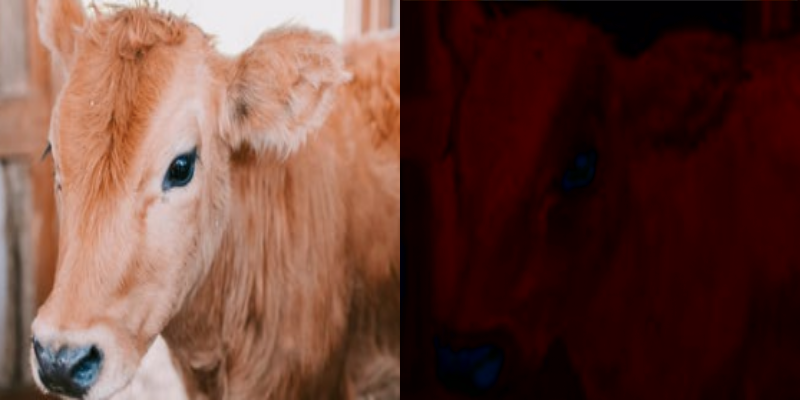

 54/291 [====>.........................] - ETA: 9:34 - loss: 0.4945 - custom_PSNR: 7.2385

In [0]:
optimizer = Adam(lr=0.00001)
metric={"PSNR":custom_PSNR,'SSIM':SSIM}
model = build_model(scale)
try:
  model.load_weights('model.h5')
except:
  pass 
show=CustomCallback(model=model)
callbacks = [ModelCheckpoint(filepath='model.h5', monitor='loss', save_best_only=True),
            show,PlotLossesKeras()]
'''
for i,layer in enumerate(model.layers):
    print(i,layer.name)
for layer in model.layers[:4]:
    layer.trainable=False
for layer in model.layers[4:]:
    layer.trainable=True    
for i,layer in enumerate(model.layers):
    print(i,layer.name,layer.trainable) 
   '''
model.compile(loss=SSIM, optimizer=optimizer,metrics=[custom_PSNR])
history=model.fit_generator(batch_generator(TRAINING_FOLDER,batch_size),
                             validation_data = batch_generator(VALIDATION_FOLDER,1),validation_steps=14,
                            callbacks=callbacks,samples_per_epoch=291, nb_epoch=500)

